# M1 - Multimodality (Contrasive Learning)

In [2]:
  !pip install -q accelerate torch
  !pip install -U scikit-learn
  !pip install umap-learn
  !pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.0 MB/s eta 0:00:00


In [3]:
!pip install pandas matplotlib datashader bokeh holoviews scikit-image colorcet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 37.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
import umap
import umap.plot
import plotly.graph_objs as go
import plotly.io as pio

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

## Loading MNIST Dataset

In [ ]:
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm

class MNISTDataset(Dataset):
    def __init__(self, data_df: pd.DataFrame, transform=None, is_test=False):
        # For the intiaition of the function
        super(MNISTDataset, self).__init__()
        dataset = []
        labels_positive = {}
        labels_negative = {}
        if is_test == False:
            for i in list(data_df.label.unique()):
                labels_positive[i] = data_df[data_df.label == i].to_numpy()
            # for each label create a set of image of various label
            for i in list(data_df.label.unique()):
                labels_negative[i] = data_df[data_df.label != i].to_numpy()

        for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
            data = row.to_numpy()

            if is_test:
                label = -1
                first = data.reshape(28, 28)
                second = -1
                dis = -1
            else:
                # label and image of the index for each row in df
                label = data[0]
                first = data[1:].reshape(28, 28)
                # probability of same label image == 0.5
                if np.random.randint(0, 2) == 0:
                    # randomly select same label image
                    second = labels_positive[label][
                        np.random.randint(0, len(labels_positive[label]))
                    ]
                else:
                    # randomly select different label
                    second = labels_negative[label][
                        np.random.randint(0, len(labels_negative[label]))
                    ]
                # cosine is 1 for same and 0 for different label
                dis = 1.0 if second[0] == label else 0.0
                second = second[1:].reshape(28, 28)

            # apply transform on both images
            if transform is not None:
                first = transform(first.astype(np.float32))
                if second is not -1:
                    second = transform(second.astype(np.float32))
            # this random list is created once and used in every epoch
            dataset.append((first, second, dis, label))

        self.dataset = dataset
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        return self.dataset[i]

In [6]:
df = pd.read_csv('digit/train.csv')
val_count = 1000
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])


dataset = MNISTDataset(df.iloc[:-val_count], default_transform)
val_dataset = MNISTDataset(df.iloc[-val_count:], default_transform)

100%|██████████| 1000/1000 [00:00<00:00, 1414.80it/s]


## DataLoaders

In [7]:

trainLoader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)

valLoader = DataLoader(val_dataset,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)

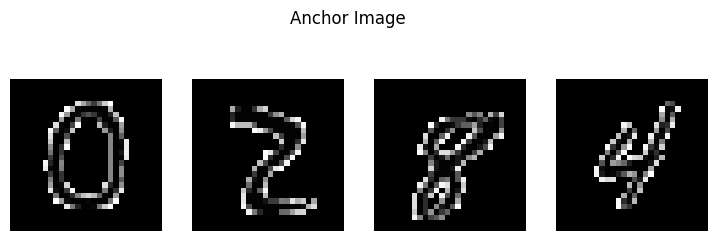

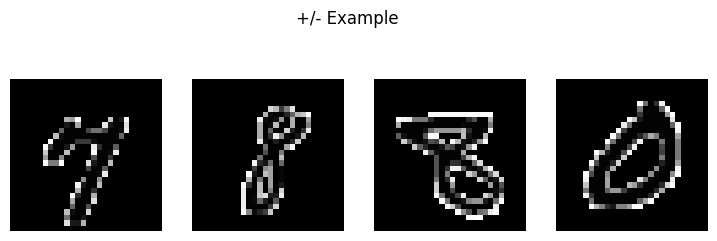

In [8]:
def show_images(images, title=''):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(9, 3))
    for i in range(num_images):
        img = np.squeeze(images[i])
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()


for batch_idx, (anchor_images, contrastive_images, distances, labels) in enumerate(trainLoader):
    anchor_images = anchor_images.numpy()
    contrastive_images = contrastive_images.numpy()
    labels = labels.numpy()

    show_images(anchor_images[:4], title='Anchor Image')
    show_images(contrastive_images[:4], title='+/- Example')

    break


## Build Neural Network Architecture

In [9]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        )
        self.linear1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 64),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        return x

In [10]:
net = Network()

device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda:0')

net = net.to(device)
device

device(type='cuda', index=0)

## Contrastive Loss Function

In [11]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.similarity = nn.CosineSimilarity(dim=-1, eps=1e-7)

    def forward(self, anchor, contrastive, distance):
        score = self.similarity(anchor, contrastive)
        return nn.MSELoss()(score, distance)

In [12]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ContrastiveLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.3)

In [16]:
def model(epoch_count=100):
    net = Network().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    lrs = []
    losses = []
    best_loss = float('inf')
    best_model = None

    for epoch in range(epoch_count):
        net.train()
        epoch_loss = 0
        batches = 0

        print(f'Epoch {epoch+1}/{epoch_count}')
        lrs.append(optimizer.param_groups[0]['lr'])
        print(f'Learning rate: {lrs[-1]:.6f}')

        for anchor, contrastive, distance, _ in tqdm(trainLoader, desc="Training"):
            batches += 1
            optimizer.zero_grad()

            anchor_out = net(anchor.to(device))
            contrastive_out = net(contrastive.to(device))
            distance = distance.to(torch.float32).to(device)

            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = epoch_loss / batches
        losses.append(avg_loss)
        scheduler.step()

        print(f'Epoch loss: {avg_loss:.4f}')

        # Save the best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = net.state_dict()
            print(f'New best model saved with loss: {best_loss:.4f}')

        # Save a checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pt')
            torch.save(net.state_dict(), checkpoint_path)
            print(f'Checkpoint saved at epoch {epoch+1}')

    # Save the best model at the end of training
    best_model_path = os.path.join(checkpoint_dir, 'best_model.pt')
    torch.save(best_model, best_model_path)
    print(f'Best model saved with loss: {best_loss:.4f}')

    return {
        "net": net,
        "losses": losses,
        "best_loss": best_loss
    }

In [19]:
import os

# Directory to save the checkpoints
checkpoint_dir = 'checkpoints/'

# Ensure directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [20]:
training_result = model()
model = training_result["net"]

Epoch 1/100
Learning rate: 0.001000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.1058
New best model saved with loss: 0.1058
Epoch 2/100
Learning rate: 0.001000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0339
New best model saved with loss: 0.0339
Epoch 3/100
Learning rate: 0.001000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0227
New best model saved with loss: 0.0227
Epoch 4/100
Learning rate: 0.001000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0176
New best model saved with loss: 0.0176
Epoch 5/100
Learning rate: 0.001000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0147
New best model saved with loss: 0.0147
Epoch 6/100
Learning rate: 0.001000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0124
New best model saved with loss: 0.0124
Epoch 7/100
Learning rate: 0.001000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0111
New best model saved with loss: 0.0111
Epoch 8/100
Learning rate: 0.001000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0098
New best model saved with loss: 0.0098
Epoch 9/100
Learning rate: 0.001000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0099
Epoch 10/100
Learning rate: 0.001000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0091
New best model saved with loss: 0.0091
Checkpoint saved at epoch 10
Epoch 11/100
Learning rate: 0.000100


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0069
New best model saved with loss: 0.0069
Epoch 12/100
Learning rate: 0.000100


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0057
New best model saved with loss: 0.0057
Epoch 13/100
Learning rate: 0.000100


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0049
New best model saved with loss: 0.0049
Epoch 14/100
Learning rate: 0.000100


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0046
New best model saved with loss: 0.0046
Epoch 15/100
Learning rate: 0.000100


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0046
Epoch 16/100
Learning rate: 0.000100


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0044
New best model saved with loss: 0.0044
Epoch 17/100
Learning rate: 0.000100


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0044
New best model saved with loss: 0.0044
Epoch 18/100
Learning rate: 0.000100


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0041
New best model saved with loss: 0.0041
Epoch 19/100
Learning rate: 0.000100


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0044
Epoch 20/100
Learning rate: 0.000100


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0042
Checkpoint saved at epoch 20
Epoch 21/100
Learning rate: 0.000010


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
New best model saved with loss: 0.0036
Epoch 22/100
Learning rate: 0.000010


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0038
Epoch 23/100
Learning rate: 0.000010


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0040
Epoch 24/100
Learning rate: 0.000010


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0041
Epoch 25/100
Learning rate: 0.000010


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0038
Epoch 26/100
Learning rate: 0.000010


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0039
Epoch 27/100
Learning rate: 0.000010


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0039
Epoch 28/100
Learning rate: 0.000010


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Epoch 29/100
Learning rate: 0.000010


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0039
Epoch 30/100
Learning rate: 0.000010


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Checkpoint saved at epoch 30
Epoch 31/100
Learning rate: 0.000001


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
New best model saved with loss: 0.0035
Epoch 32/100
Learning rate: 0.000001


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
New best model saved with loss: 0.0035
Epoch 33/100
Learning rate: 0.000001


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 34/100
Learning rate: 0.000001


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
New best model saved with loss: 0.0035
Epoch 35/100
Learning rate: 0.000001


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0038
Epoch 36/100
Learning rate: 0.000001


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0038
Epoch 37/100
Learning rate: 0.000001


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Epoch 38/100
Learning rate: 0.000001


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
Epoch 39/100
Learning rate: 0.000001


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Epoch 40/100
Learning rate: 0.000001


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Checkpoint saved at epoch 40
Epoch 41/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
Epoch 42/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 43/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
Epoch 44/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0039
Epoch 45/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0040
Epoch 46/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 47/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 48/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0038
Epoch 49/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 50/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Checkpoint saved at epoch 50
Epoch 51/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0039
Epoch 52/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0038
Epoch 53/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Epoch 54/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0040
Epoch 55/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Epoch 56/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
Epoch 57/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0038
Epoch 58/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0033
New best model saved with loss: 0.0033
Epoch 59/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 60/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Checkpoint saved at epoch 60
Epoch 61/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 62/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 63/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0040
Epoch 64/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Epoch 65/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 66/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 67/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 68/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 69/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0039
Epoch 70/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Checkpoint saved at epoch 70
Epoch 71/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 72/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 73/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0039
Epoch 74/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Epoch 75/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0034
Epoch 76/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
Epoch 77/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 78/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
Epoch 79/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 80/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Checkpoint saved at epoch 80
Epoch 81/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Epoch 82/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Epoch 83/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0038
Epoch 84/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Epoch 85/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0039
Epoch 86/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
Epoch 87/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 88/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0033
Epoch 89/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0034
Epoch 90/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
Checkpoint saved at epoch 90
Epoch 91/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0038
Epoch 92/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0038
Epoch 93/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Epoch 94/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0042
Epoch 95/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
Epoch 96/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0035
Epoch 97/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Epoch 98/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0039
Epoch 99/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0036
Epoch 100/100
Learning rate: 0.000000


Training:   0%|          | 0/2563 [00:00<?, ?it/s]

Epoch loss: 0.0037
Checkpoint saved at epoch 100
Best model saved with loss: 0.0033


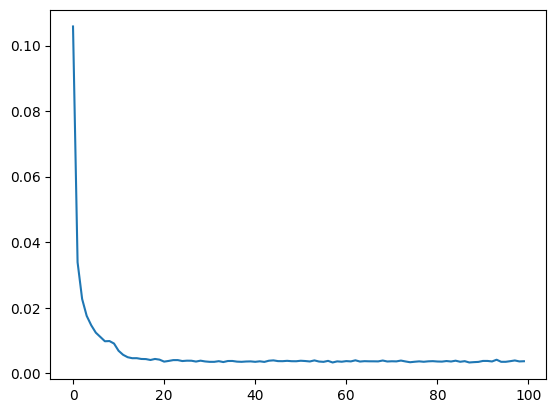

In [21]:
plt.plot(training_result["losses"])
plt.show()

In [22]:
outputs = []
labels = []
net.eval()
# loop over train dataset and get embedding for each image
with torch.no_grad():
    for first, second, dis, label in tqdm(trainLoader):
        # Appends the embeddings and labels to their respective lists
        outputs.append(net(first.to(device)).cpu().detach().numpy())
        labels.append(label.numpy())

# Converting the list into the numpy array
outputs = np.concatenate(outputs)
labels = np.concatenate(labels)

  0%|          | 0/2563 [00:00<?, ?it/s]

### 64 Dimensional Representations of the MNIST Training Set

In [24]:
encoded_data = []
labels = []

with torch.no_grad():
    for anchor, _, _, label in tqdm(trainLoader):
        output = model(anchor.to(device))
        encoded_data.extend(output.cpu().numpy())
        labels.extend(label.cpu().numpy())

encoded_data = np.array(encoded_data)
labels = np.array(labels)

  0%|          | 0/2563 [00:00<?, ?it/s]

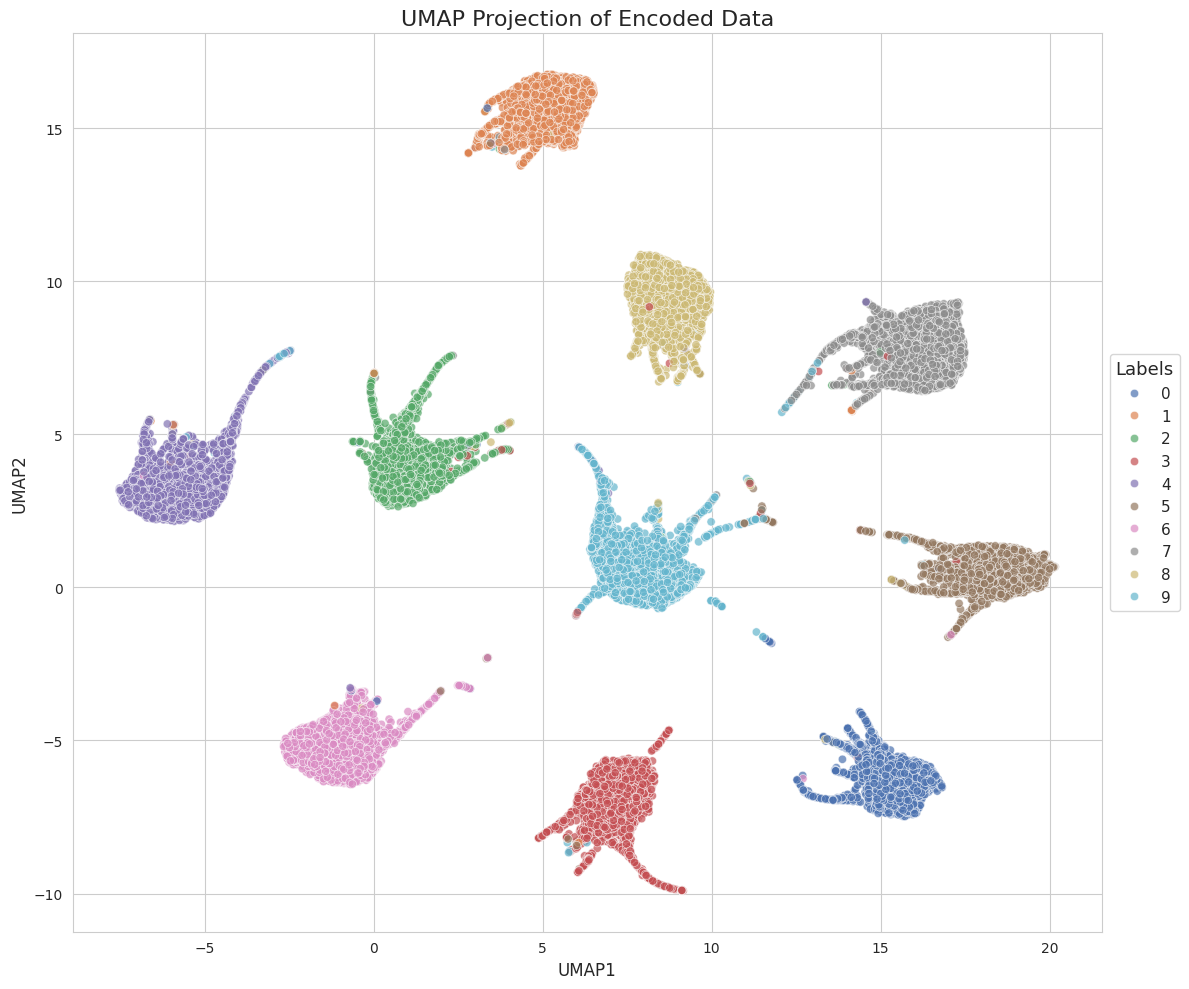

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_umap(encoded_data, labels, random_state=42):
    # Create UMAP embeddings
    mapper = umap.UMAP(random_state=random_state, metric='cosine')
    umap_embeddings = mapper.fit_transform(encoded_data)

    # Create a DataFrame for easy plotting
    df = pd.DataFrame({
        'UMAP1': umap_embeddings[:, 0],
        'UMAP2': umap_embeddings[:, 1],
        'Label': labels
    })

    # Set up the plot style
    plt.figure(figsize=(12, 10))
    sns.set_style("whitegrid")
    sns.set_palette("deep")

    # Create the scatter plot
    sns_plot = sns.scatterplot(
        data=df,
        x='UMAP1',
        y='UMAP2',
        hue='Label',
        palette='deep',
        legend='full',
        alpha=0.7
    )

    # Customize the plot
    plt.title('UMAP Projection of Encoded Data', fontsize=16)
    plt.xlabel('UMAP1', fontsize=12)
    plt.ylabel('UMAP2', fontsize=12)
    plt.legend(title='Labels', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Usage
plot_umap(encoded_data, labels)